#### Seasonal Auto Regrerssive Integrated Moving Average with eXogenous regressor model

###### Analyzing the daily bike demand in (a city), provided by (source ofdataset). The data looks at the hourly renting count, the weather conditions and xy over from (date1) to (date2).

In [166]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import mean_squared_log_error


from sklearn.pipeline import Pipeline, make_pipeline

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

In [167]:
#!pip install pandas_profiling

In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from pandas_profiling import ProfileReport

In [205]:
train = pd.read_csv("../data/train.csv", index_col=0, parse_dates=True)
test = pd.read_csv("../data/test.csv", index_col=0, parse_dates=True)
df = train.copy(deep=True)

In [170]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='datetime'>

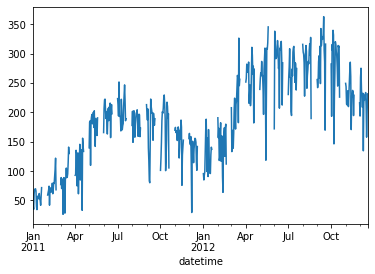

In [171]:
df.resample('D')['count'].mean().plot()

###### We can see a clear anual seasonality pattern as well as an upward trend within the years.

<AxesSubplot:xlabel='datetime'>

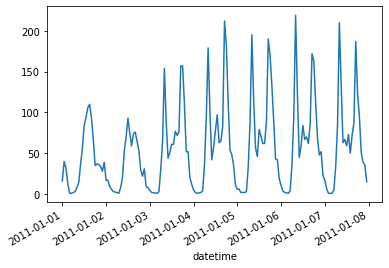

In [172]:
df.loc["2011-01-01":"2011-01-07"]["count"].plot()

## Exploratory Data Analysis & Feature Engineering

In [173]:
def add_time_features(df):
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["week"] = df.index.week
    df["day"] = df.index.day
    df["hour"] = df.index.hour

    df["DayOfWeek"] = df.index.dayofweek

# cyclicle features
    # daily
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] /24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] /24)
    # month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] /12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] /12)

# categorical features
    df["rushhour"] = 0
    df.loc[(df.workingday == 1) & (df.hour >= 7)&(df.hour <= 9), "rushhour"] = 1
    df.loc[(df.workingday == 1) & (df.hour >= 17)&(df.hour <= 19), "rushhour"] = 1

    df["daynight"] = np.NaN
    df.loc[(df.hour <= 19)&(df.hour >= 7), "daynight"] = "day"    # day
    df.loc[(df.hour <= 6)|(df.hour >= 20), "daynight"] = "night"    # night
    
    return df

In [206]:
add_time_features(df)
df.head(4)#

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  ...  week  day  \
datetime                                                      ...              
2011-01-01 00:00:00        81        0.0       3          13  ...    52    1   
2011-01-01 01:00:00        80        0.0       8          32  ...    52    1   
2011-01-01 02:00:00        80        0.0       5          27  ...    52    1   
2011-01-01 03:00:00        75        0.0       3          10  ...    52    1   

                     hour  DayOfWeek  hour_sin  hour_cos  month_sin  \
datetime                                                              
2011-01-01 00:00:00     0          5  0.000000  1.000000        0.5   
2011-01-01 01:00:00     1          5  0.258819  0.965926        0.5   
2011-01-01 02:00:00     2          5  0.500000  0.866025        0.5   
2011-01-01 03:00:00     3          5  0.707107  0.707107        0.5   

                     month_cos  rushhour  daynight  
datetime                                            
2011-01-01 00:00:00   0.866025         0     night  
2011-01-01 01:00:00   0.866025         0     night  
2011-01-01 02:00:00   0.866025         0     night  
2011-01-01 03:00:00   0.866025         0     night  

[4 rows x 23 columns]

In [175]:
def get_graph(df, fig_name, y="count"):

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(30,15)
    dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    mon_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    sns.barplot(data = df, x="year", y=y, ax = axes[0,0])
    sns.barplot(data = df, x="month", y=y, ax = axes[0,1]).set_xticklabels(mon_labels)
    sns.pointplot(data = df, x="hour", y=y, ax = axes[1,0], hue = "DayOfWeek")
    sns.pointplot(data = df, x="DayOfWeek", y=y, ax = axes[1,1], hue = "year").set_xticklabels(dow_labels)
    fig.savefig(fig_name)
    fig.show()

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


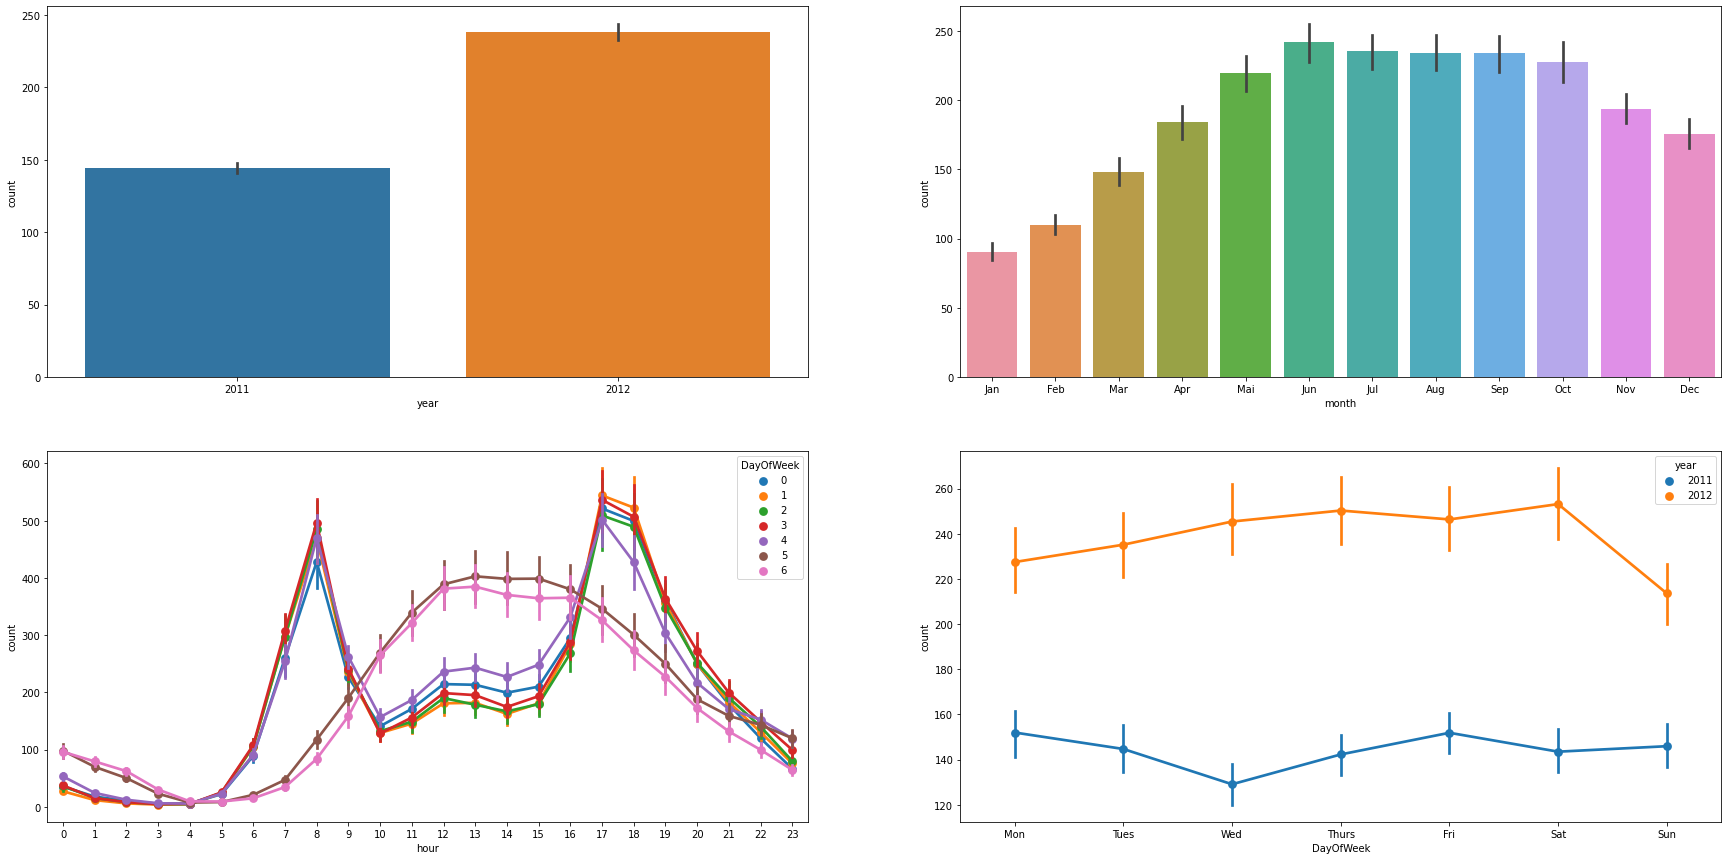

In [176]:
get_graph(df, "eda_plots")

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


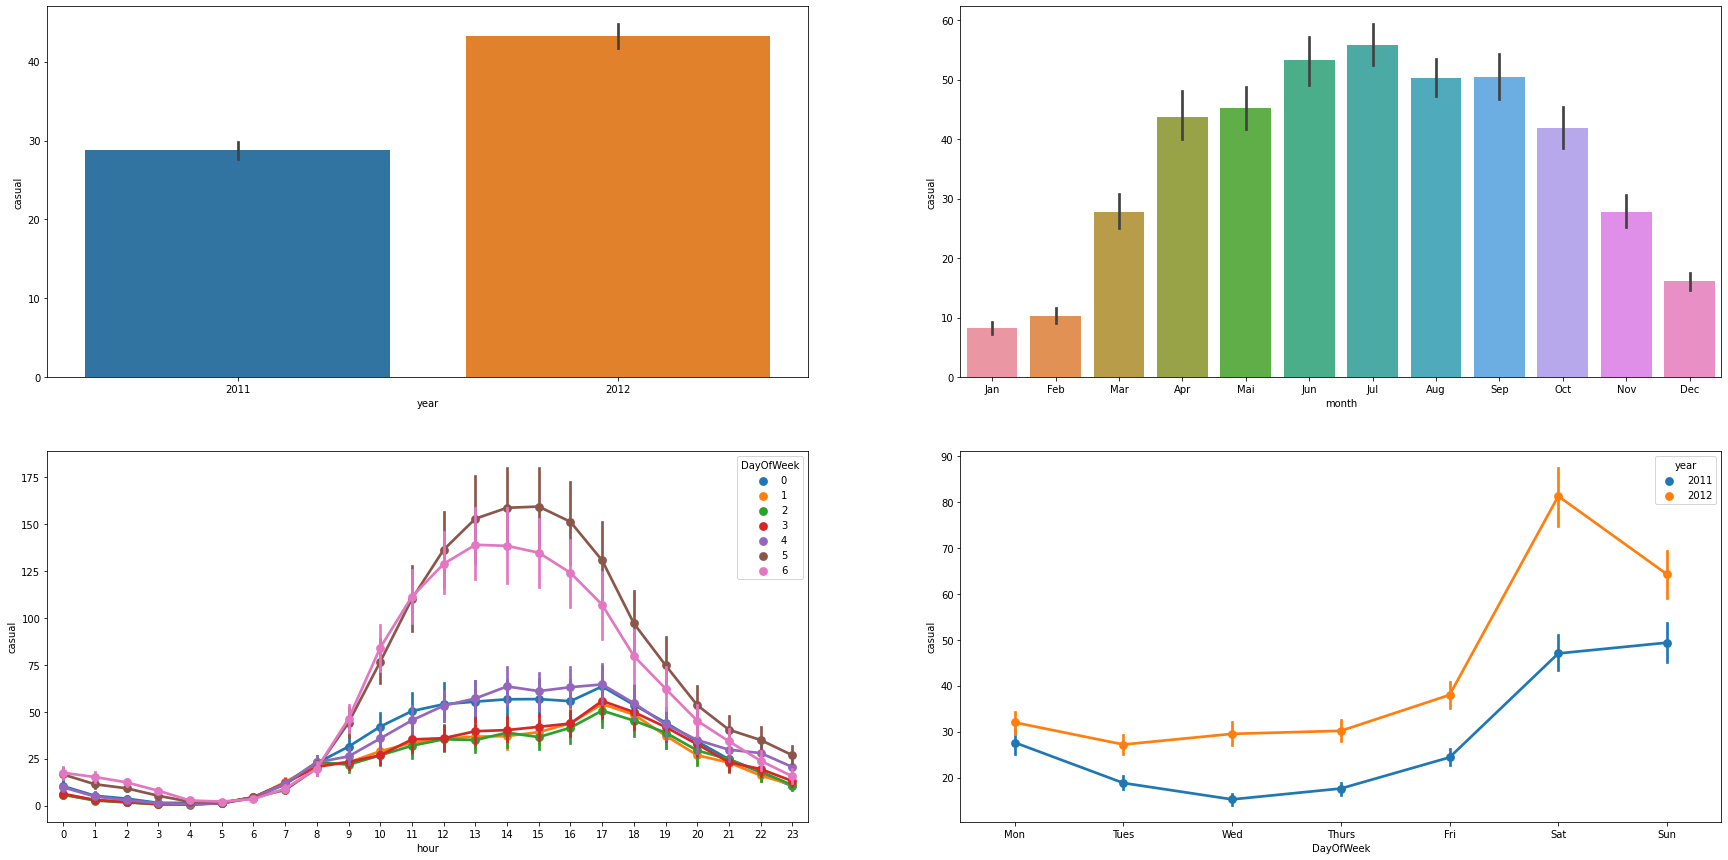

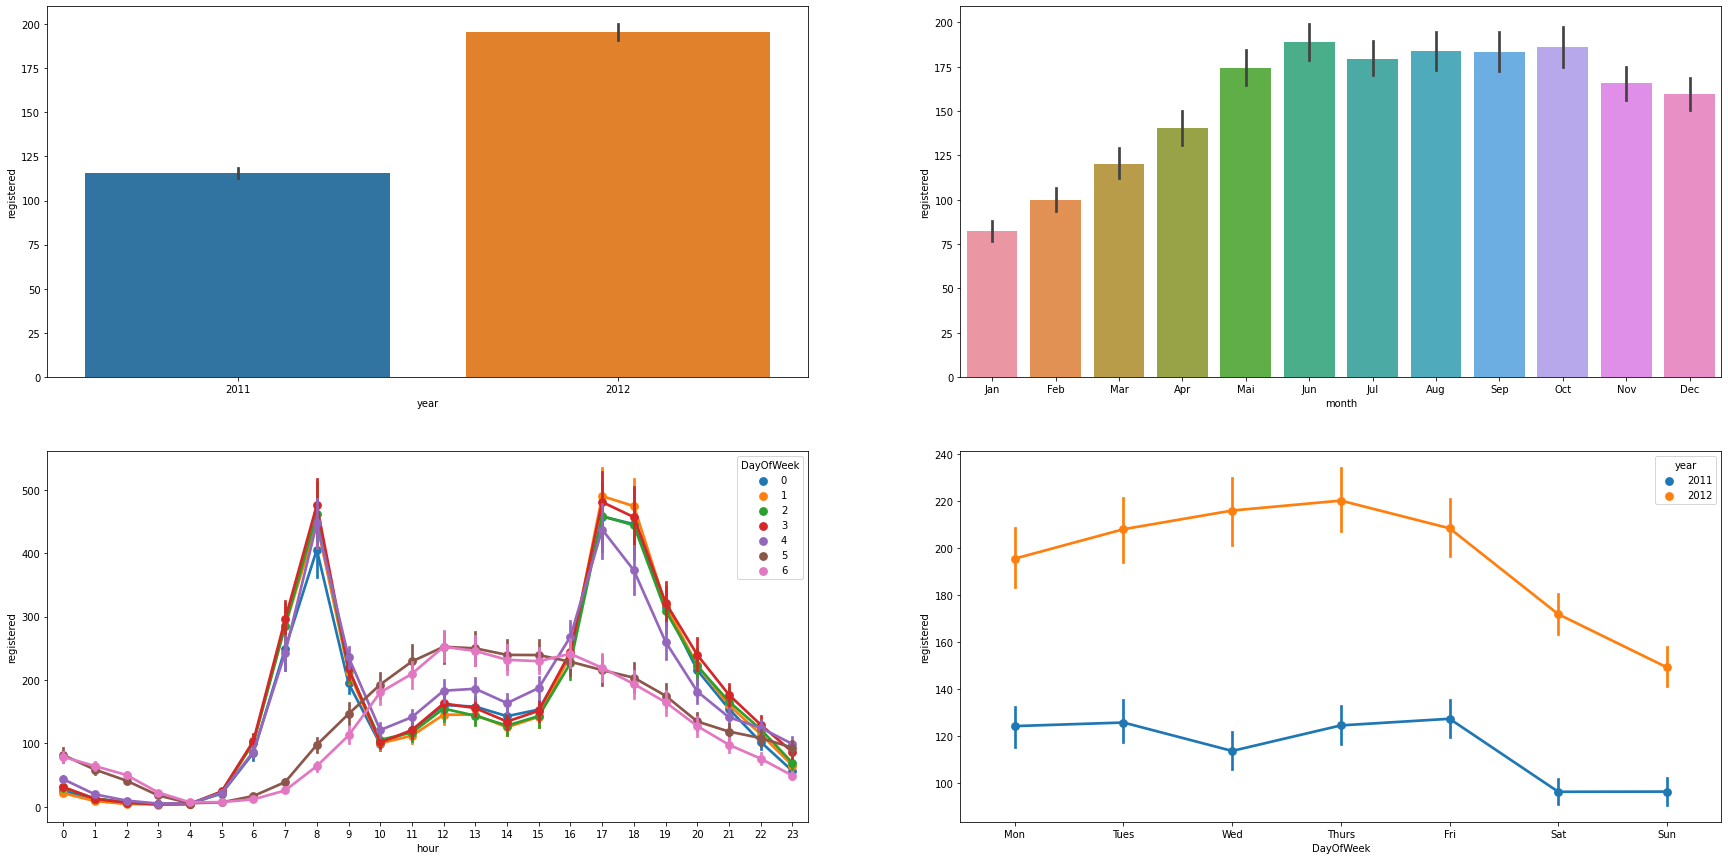

In [177]:
get_graph(df, "eda_casual_graph", y="casual")
get_graph(df, "eda_registered_graph", y="registered")

- Casual bike renters use the bikes from 7am increasingly throughout the day with peak times between 2-5 pm, declining until midnight. 
- They use them throughout the whole week, but especially on the weekend
- There is a seasonal preference to rend the bikes, from april to october.
- In 2012 the demand increased compared to the year before.

- registered bike renters use the bikes from 6am throughout the day with two peak times. In the morning from 7-8 am and in the afternoon from 5-6 pm. 
- The demand is similar throughout the whole week 
- The bikes are used throughout the year, mostly though in the months from mai till december.
- In 2012 the demand increased compared to the year before. 

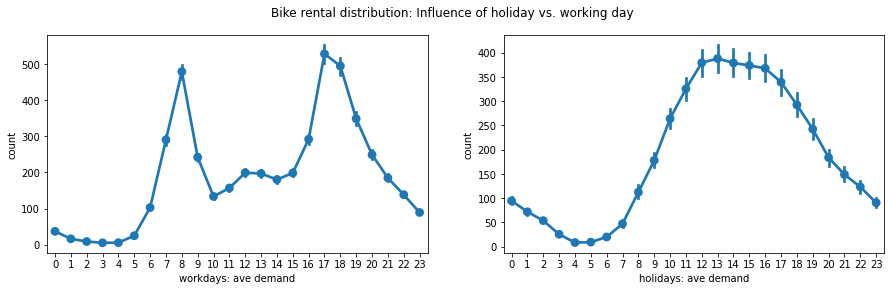

In [178]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,4)

weekday_df = df[df['workingday'] == 1]
holiday_df = df[df['workingday'] == 0]

sns.pointplot(data = weekday_df, x="hour", y="count", ax = axes[0])
sns.pointplot(data = holiday_df, x="hour", y="count", ax = axes[1])
plt.suptitle('Bike rental distribution: Influence of holiday vs. working day')
axes[0].set_xlabel("workdays: ave demand")
axes[1].set_xlabel("holidays: ave demand")

fig.savefig("Bike_rental_distribution_holiday_working_day.png")

- on holidays the bike demand ist peaking 12am to 4pm for all of the users.

summary
###### DAILY: during the week there are two peaks of bike demand, one in the morning and one in the afternoon. on weekend the bikes are mainly used during the day, with a peak in noon/early afternoon. On holidays there is only one peak of bike demand during the day, similar to the weekend distribution. 
###### MONTHLY: During the year the bike demand in the individual months is slightly different between registered users and casual users. The first use the bikes all year around, mainly from mai till december, the latter use the bikes far less (lower toal number), but mainly from april till october.
###### YEARLY: There is an inrease in demand visible from 2011 to 2012

# Split Data

In [179]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Preprocessing the data

### Remove skewness of data (target variable)

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

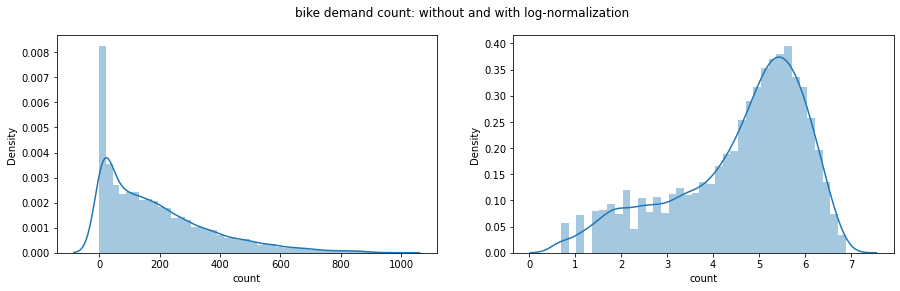

In [207]:
# data is presenting a left skew
# to remove the skewness, apply log'

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,4)
plt.suptitle('bike demand count: without and with log-normalization')

sns.distplot(df["count"], ax = axes[0])
sns.distplot(np.log1p(df["count"]), ax = axes[1])


### Remove the outliers (that have a residual < stdev*3)

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='count'>

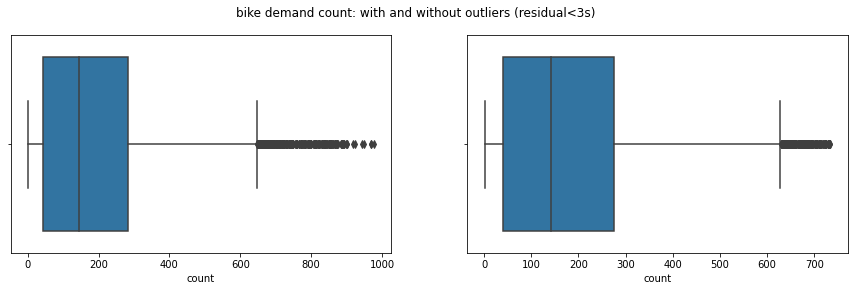

In [208]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,4)
plt.suptitle('bike demand count: with and without outliers (residual<3s)')

sns.boxplot(df["count"], ax = axes[0])
dfx = df[np.abs(df["count"])-df["count"].mean()<=(3*df["count"].std())]
sns.boxplot(dfx["count"], ax = axes[1])

In [215]:
def preprocessing(df):
    # remove skewness from data
    df["log_count"] = np.log1p(df["count"])
    # remove outliers that have a residual of <3sigma
    df = df[np.abs(df["count"])-df["count"].mean()<=(3*df["count"].std())]

    return df

In [218]:
df = preprocessing(df)

# Feature engineering

In [219]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'week', 'day', 'hour', 'DayOfWeek', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'rushhour', 'daynight', 'log_count'],
      dtype='object')

In [222]:
X = df.drop(['count', 'log_count', 'casual', 'registered'], axis=1)
y = df['log_count']

# y_log = np.log1p(y)

## Defining transformers and features

In [199]:
# numerical features
num_tr = MinMaxScaler()
num_fe = ["weather", "temp", "atemp", "humidity", "windspeed"]

# categorical features
## cat_tr = KBinsDiscretizer(n_bins=12, encode='onehot')
cat_tr = OneHotEncoder(drop="first")
cat_fe = ["season", "holiday", "workingday", "rushhour", "daynight", "DayOfWeek"]

In [200]:
#Creating column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tr, num_fe),
        ("cat", cat_tr, cat_fe)
    ], 
    remainder="passthrough")

### Linear Regression Model

In [264]:
pipeline_lin = make_pipeline(preprocessor, LinearRegression())
pipeline_lin.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['weather', 'temp', 'atemp',
                                                   'humidity', 'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'holiday',
                                                   'workingday', 'rushhour',
                                                   'daynight',
                                                   'DayOfWeek'])])),
                ('linearregression', LinearRegression())])

In [224]:
cross_val_score(pipeline_lin, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True))

array([0.75792679, 0.77154234, 0.75921309, 0.76079252, 0.75927407])

In [225]:
pipeline_lin.score(X, y)

0.7632924551432441

In [249]:
ypred_log1 = np.exp(pipeline_lin.predict(X))-1
ypred_log1 = pd.DataFrame(ypred_log1, index = df.index, columns=["predicted"])
ypred_log1

predicted
datetime                       
2011-01-01 00:00:00    5.965523
2011-01-01 01:00:00    5.522477
2011-01-01 02:00:00    5.636825
2011-01-01 03:00:00    6.419015
2011-01-01 04:00:00    7.685308
...                         ...
2012-12-19 19:00:00  712.425967
2012-12-19 20:00:00  166.978682
2012-12-19 21:00:00  129.445027
2012-12-19 22:00:00  114.989947
2012-12-19 23:00:00   94.067410

[10739 rows x 1 columns]

In [250]:
np.sqrt(mean_squared_log_error(y, ypred_log1))

3.0523198676563514

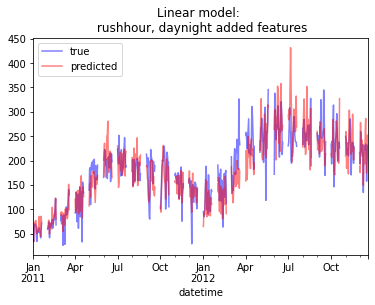

In [257]:
ax = df['count'].resample('D').mean().plot(c='b', alpha=0.5, label='true')
ypred_log1.resample('D').mean().plot(c='r', alpha=0.5, ax=ax, label='predicted')

ax.set_title('Linear model: \n rushhour, daynight added features')
plt.legend()

plt.savefig("LinearRegressionModel_true_pred")

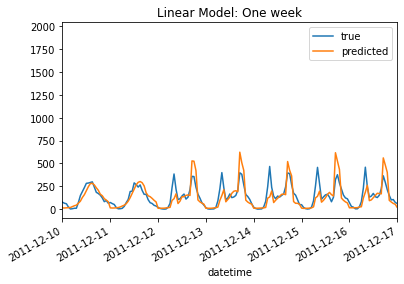

In [258]:
ax = df['count'].plot(label='true')
ypred_log1.plot(ax=ax)

plt.xlim(('2011-12-10 00:00:00', '2011-12-17 00:00:00'))
plt.title('Linear Model: One week')
plt.legend()

plt.savefig("LinearRegressionModel_true_pred_oneweek")

### Linear Regression Model + Polynomial Features

In [268]:
poly = PolynomialFeatures(degree=2, include_bias=False)

pipeline_lin_poly = make_pipeline(preprocessor, poly, LinearRegression())
pipeline_lin_poly.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['weather', 'temp', 'atemp',
                                                   'humidity', 'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'holiday',
                                                   'workingday', 'rushhour',
                                                   'daynight',
                                                   'DayOfWeek'])])),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [269]:
cross_val_score(pipeline_lin_poly, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True))

array([0.92193033, 0.92511222, 0.92204087, 0.92628963, 0.92247146])

In [272]:
pipeline_lin_poly.score(X,y)

0.9294539991136941

In [273]:
ypred_log1_lp = np.exp(pipeline_lin_poly.predict(X))-1
ypred_log1_lp = pd.DataFrame(ypred_log1, index = df.index, columns=["predicted"])
ypred_log1_lp

predicted
datetime                       
2011-01-01 00:00:00    5.965523
2011-01-01 01:00:00    5.522477
2011-01-01 02:00:00    5.636825
2011-01-01 03:00:00    6.419015
2011-01-01 04:00:00    7.685308
...                         ...
2012-12-19 19:00:00  712.425967
2012-12-19 20:00:00  166.978682
2012-12-19 21:00:00  129.445027
2012-12-19 22:00:00  114.989947
2012-12-19 23:00:00   94.067410

[10739 rows x 1 columns]

In [274]:
np.sqrt(mean_squared_log_error(y, ypred_log1_lp))

3.0523198676563514

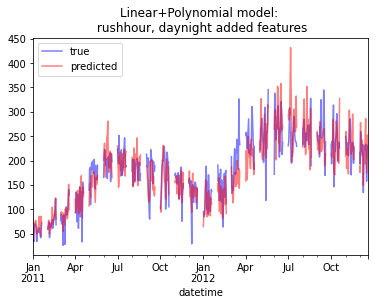

In [276]:
ax = df['count'].resample('D').mean().plot(c='b', alpha=0.5, label='true')
ypred_log1_lp.resample('D').mean().plot(c='r', alpha=0.5, ax=ax, label='predicted')

ax.set_title('Linear+Polynomial model: \n rushhour, daynight added features')
plt.legend()

plt.savefig("LinearRegression_Polynomial_Model_true_pred")

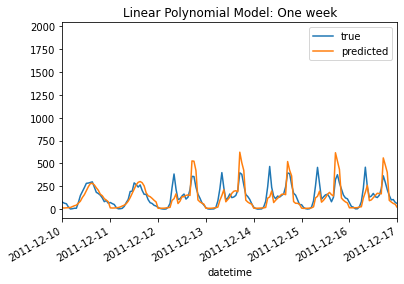

In [277]:
ax = df['count'].plot(label='true')
ypred_log1_lp.plot(ax=ax)

plt.xlim(('2011-12-10 00:00:00', '2011-12-17 00:00:00'))
plt.title('Linear Polynomial Model: One week')
plt.legend()

plt.savefig("LinearRegression_Polynomial_Model_true_pred_oneweek")

In [107]:
m_bike_forest = make_pipeline(preprocessor, PolynomialFeatures(degree=3), RandomForestRegressor(max_depth=5, n_estimators=50))
#m_bike_test = preprocessor #make_pipeline(preprocessor,PolynomialFeatures(degree=3))

In [108]:
m_bike_linear.fit (X_train, y_train)
m_bike_forest.fit (X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=6))]),
                                                  ['humidity', 'windspeed',
                                                   'temp']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['workingday', 'weather',
                                                   'holiday', 'season'])])),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('randomforestregressor',
                

In [109]:
ylogpred = m_bike_linear.predict(x_test)
ypred = np.exp(ylogpred)
y_test_unlog = np.exp(y_test)

print ('RMSLE Linear:',np.sqrt(mean_squared_log_error(y_test_unlog, ypred)))

RMSLE Linear: 2.193416776836317


In [75]:
ypred

array([154.85983814,  36.17242824, 169.33252509, ..., 419.91002198,
         9.6180024 , 255.04301281])

In [79]:
x_test["ypred"] = ypred
x_test

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-07-19 11:00:00       3        0           1        1  33.62  40.150   
2012-01-16 06:00:00       1        1           0        1   4.10   6.820   
2011-12-11 18:00:00       4        0           0        1   9.84  11.365   
2012-08-15 10:00:00       3        0           1        2  29.52  34.090   
2012-06-15 23:00:00       2        0           1        1  25.42  31.060   
...                     ...      ...         ...      ...    ...     ...   
2011-05-08 17:00:00       2        0           0        3  23.78  27.275   
2012-01-17 04:00:00       1        0           1        3  13.12  15.150   
2012-11-04 14:00:00       4        0           0        1  16.40  20.455   
2012-01-01 05:00:00       1        0           0        1  11.48  14.395   
2012-05-15 13:00:00       2        0           1        3  26.24  30.305   

                     humidity  windspeed  year  month  week  day  hour  \
datetime                                                                 
2011-07-19 11:00:00        59     0.0000  2011      7    29   19    11   
2012-01-16 06:00:00        54     6.0032  2012      1     3   16     6   
2011-12-11 18:00:00        48    12.9980  2011     12    49   11    18   
2012-08-15 10:00:00        62    12.9980  2012      8    33   15    10   
2012-06-15 23:00:00        53    16.9979  2012      6    24   15    23   
...                       ...        ...   ...    ...   ...  ...   ...   
2011-05-08 17:00:00        49    19.0012  2011      5    18    8    17   
2012-01-17 04:00:00        66    22.0028  2012      1     3   17     4   
2012-11-04 14:00:00        40    12.9980  2012     11    44    4    14   
2012-01-01 05:00:00        81     7.0015  2012      1    52    1     5   
2012-05-15 13:00:00        73    12.9980  2012      5    20   15    13   

                     DayOfWeek  Quarter  DayOfYear  WeekOfYear       ypred  
datetime                                                                    
2011-07-19 11:00:00          1        3        200          29  154.859838  
2012-01-16 06:00:00          0        1         16           3   36.172428  
2011-12-11 18:00:00          6        4        345          49  169.332525  
2012-08-15 10:00:00          2        3        228          33  193.187245  
2012-06-15 23:00:00          4        2        167          24  128.870063  
...                        ...      ...        ...         ...         ...  
2011-05-08 17:00:00          6        2        128          18  241.080932  
2012-01-17 04:00:00          1        1         17           3    7.714249  
2012-11-04 14:00:00          6        4        309          44  419.910022  
2012-01-01 05:00:00          6        1          1          52    9.618002  
2012-05-15 13:00:00          1        2        136          20  255.043013  

[2178 rows x 18 columns]

(0.0, 700.0)

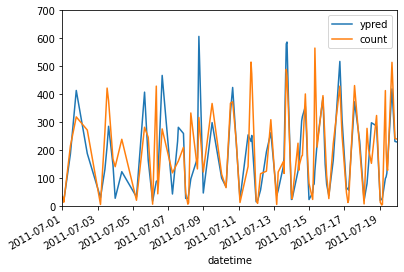

In [97]:
x_test["ypred"].plot()
y_test_unlog.plot()
plt.legend()
plt.xlim("2011-07-01","2011-07-20")
plt.ylim(0, 700)

(0.0, 700.0)

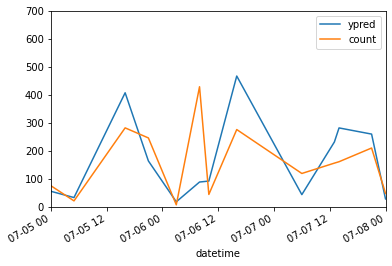

In [100]:
x_test["ypred"].plot()
y_test_unlog.plot()
plt.legend()
plt.xlim("2011-07-05 00:00:00","2011-07-08 00:00:00")
plt.ylim(0, 700)

In [76]:
print ("Linear Train Score is:", m_bike_linear.score(X_train, y_train))
print ("Forest Train Score is:", m_bike_forest.score(X_train, y_train))

Linear Train Score is: 0.7336007383638921
Forest Train Score is: 0.8695150182028776


In [77]:
print ("Linear Test Score is:", m_bike_linear.score(x_test, y_test))
print ("Linear Test Score is:", m_bike_forest.score(x_test, y_test))

Linear Test Score is: 0.688603362762253
Linear Test Score is: 0.8677922918202041
